In [45]:
pip install rasterio

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the LST GeoTIFF file
with rasterio.open("/content/LST_1_100m.tif") as src:
    lst_data = src.read(1)  # Read the first band (temperature values)

# Normalize the data to [0, 1]
lst_data_norm = (lst_data - np.min(lst_data)) / (np.max(lst_data) - np.min(lst_data))

print("Original LST Image Shape:", lst_data.shape)
print("Normalized Range:", np.min(lst_data_norm), "to", np.max(lst_data_norm))


Original LST Image Shape: (73, 79)
Normalized Range: 0.0 to 1.0


In [48]:
def extract_patches(image, patch_size, stride):

    patches = []
    h, w = image.shape
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = image[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    return np.array(patches)

# Define patch size and stride
patch_size = 24
stride = 1



hr_patches = extract_patches(lst_data_norm, patch_size, stride)
hr_patches = hr_patches.reshape(-1, patch_size, patch_size, 1)

print("Extracted HR Patches:", hr_patches.shape)


Extracted HR Patches: (2800, 24, 24, 1)


In [49]:
def create_lr_hr_pairs(hr_patches, scale=2):

    lr_patches = []
    for patch in hr_patches:
        h, w = patch.shape[:2]

        lr_patch = cv2.resize(patch, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
        lr_patch = cv2.resize(lr_patch, (w, h), interpolation=cv2.INTER_CUBIC)
        lr_patches.append(lr_patch)
    return np.array(lr_patches), hr_patches


X_train_lr, X_train_hr = create_lr_hr_pairs(hr_patches, scale=2)

X_train_lr = X_train_lr.reshape(-1, patch_size, patch_size, 1)
X_train_hr = X_train_hr.reshape(-1, patch_size, patch_size, 1)

print("LR Patches Shape:", X_train_lr.shape)
print("HR Patches Shape:", X_train_hr.shape)





LR Patches Shape: (2800, 24, 24, 1)
HR Patches Shape: (2800, 24, 24, 1)


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

def build_srcnn(patch_size):

    model = Sequential([
        Conv2D(512, (9, 9), activation='relu', padding='same', input_shape=(patch_size, patch_size, 1)),
        Conv2D(256, (5, 5), activation='relu', padding='same'),
        Conv2D(1, (5, 5), activation='linear', padding='same')
    ])


    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

srcnn_model = build_srcnn(patch_size)
srcnn_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 24, 24, 512)         │          41,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 24, 24, 256)         │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 24, 24, 1)           │           6,401 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,325,441 (12.69 MB)

 Trainable params: 3,325,441 (12.69 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Train the model
history = srcnn_model.fit(X_train_lr, X_train_hr, epochs=200, batch_size=32, validation_split=0.1)



Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0206 - mae: 0.1029 - val_loss: 0.0041 - val_mae: 0.0492
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0032 - mae: 0.0430 - val_loss: 0.0033 - val_mae: 0.0441
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0027 - mae: 0.0400 - val_loss: 0.0032 - val_mae: 0.0429
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0026 - mae: 0.0391 - val_loss: 0.0031 - val_mae: 0.0423
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0025 - mae: 0.0386 - val_loss: 0.0031 - val_mae: 0.0421
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0025 - mae: 0.0383 - val_loss: 0.0030 - val_mae: 0.0419
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0024 - mae: 0.0377 - val_loss: 0.0030 - val_mae: 0.0417
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0024 - mae: 0.0374 - val_loss: 0.0030 - val_mae: 0.0416
Epoch 9/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - lo

In [54]:

full_lr = cv2.resize(lst_data_norm, (lst_data_norm.shape[1]//2, lst_data_norm.shape[0]//2), interpolation=cv2.INTER_CUBIC)
full_lr = cv2.resize(full_lr, (lst_data_norm.shape[1], lst_data_norm.shape[0]), interpolation=cv2.INTER_CUBIC)
full_lr_input = full_lr.reshape(1, lst_data_norm.shape[0], lst_data_norm.shape[1], 1)

predicted_full = srcnn_model.predict(full_lr_input)[0, :, :, 0]

print("Super-resolution complete!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Super-resolution complete!


In [55]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

mae = np.mean(np.abs(predicted_full - lst_data_norm))
ssim_score = ssim(lst_data_norm, predicted_full, data_range=1.0)
psnr_score = psnr(lst_data_norm, predicted_full, data_range=1.0)

print(f"Full Image MAE: {mae:.4f}")
print(f"Full Image SSIM: {ssim_score:.4f}")
print(f"Full Image PSNR: {psnr_score:.2f} dB")


Full Image MAE: 0.0250
Full Image SSIM: 0.9460
Full Image PSNR: 29.00 dB


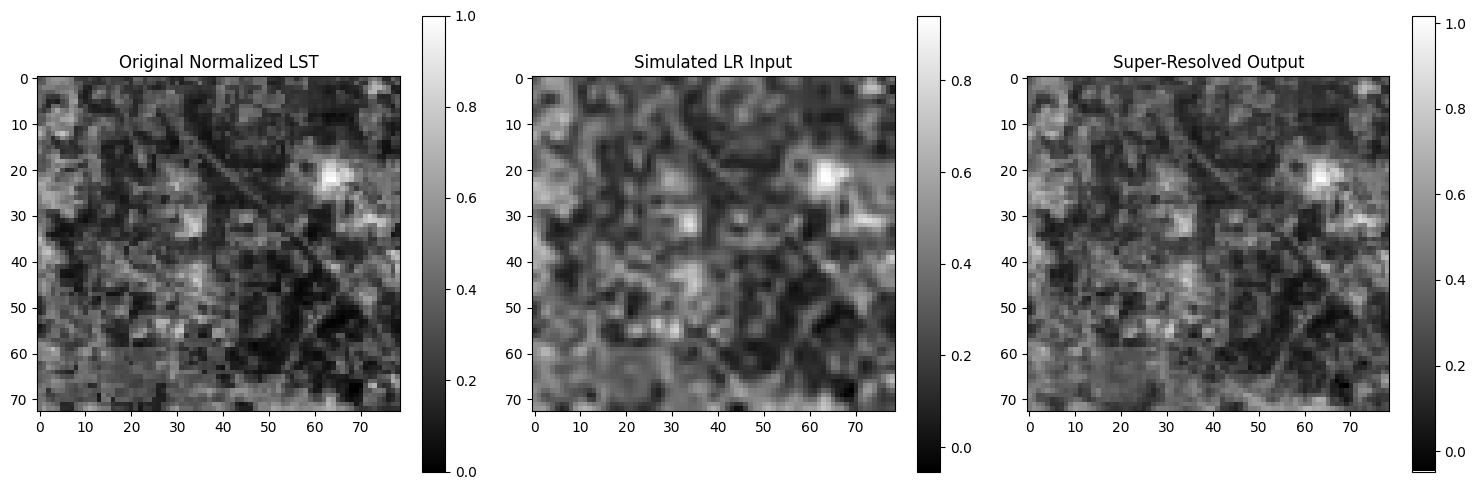

In [57]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(lst_data_norm, cmap='gray')
plt.title("Original Normalized LST")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(full_lr, cmap='gray')
plt.title("Simulated LR Input")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(predicted_full, cmap='gray')
plt.title("Super-Resolved Output")
plt.colorbar()

plt.tight_layout()
plt.show()
